### Cab-Driver Agent

In [1]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle

# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver

Using TensorFlow backend.


#### Defining Time Matrix

In [2]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

In [3]:
print(Time_matrix.max())
print(Time_matrix.min())
print(Time_matrix.mean())
print(Time_matrix.var())

11.0
0.0
3.0542857142857143
7.93705306122449


##### max time is 11 hours of travel between any 2 locations, the next state of the cab driver may increase at most by a day.

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [4]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor =0.95
        self.learning_rate = 0.01       
        self.epsilon_max = 1
        self.epsilon= 1
        self.epsilon_decay = -0.0005
        self.epsilon_min = 0.00001
#         self.epsilon_decay = 0.9991 
#         self.epsilon_min = 0.01
        
        self.batch_size = 32        
        # create replay memory using deque
        self.memory = deque(maxlen=2000)
        
        # Initialize the value of the states tracked
        self.states_tracked = []
        
        # We are going to track state [0,0,0] and action (0,3) at index 3 in the action space.
        self.track_state = np.array(env.state_encod_arch1([0,0,0])).reshape(1, 36)

        # create main model and target model
        self.model = self.build_model()

    # approximate Q function using Neural Network
    def build_model(self):
        model = Sequential()
        # Write your code here: Add layers to your neural nets       
        model.add(Dense(32, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
        
        # the output layer: output is of size num_actions
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform'))
        model.compile(loss='mse',optimizer=Adam(lr=self.learning_rate))
        model.summary
        return model



    def get_action(self, state, possible_actions_index, actions):
        
        # Write your code here:
        # get action from model using epsilon-greedy policy
        # Decay in ε after we generate each sample from the environment
    
        if np.random.rand() <= self.epsilon:
            # explore: choose a random action from the ride requests
            return random.choice(possible_actions_index)
        else:
            # choose the action with the highest q(s, a)
            # the first index corresponds to the batch size, so
            # reshape state to (1, state_size) so that the first index corresponds to the batch size
            state = np.array(env.state_encod_arch1(state)).reshape(1, 36)

            # Use the model to predict the Q_values.
            q_value = self.model.predict(state)

            # fetch the array to only those actions that are part of the ride requests.
            q_vals_possible = [q_value[0][i] for i in possible_actions_index]
        
            return possible_actions_index[np.argmax(q_vals_possible)]
        
        


    def append_sample(self, state, action, reward, next_state, done):
        # Write your code here:
        # save sample <s,a,r,s'> to the replay memory
        # appends the new agent recived output to memory buffer
        self.memory.append((state, action, reward, next_state, done))
    
    
    
    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):      
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            update_output = np.zeros((self.batch_size, self.state_size))
            update_input = np.zeros((self.batch_size, self.state_size))
            
            actions, rewards, done = [], [], []
            
            for i in range(self.batch_size):
                state, action, reward, next_state, done_boolean  = mini_batch[i]
                update_input[i] = env.state_encod_arch1(state)     
                actions.append(action)
                rewards.append(reward)
                update_output[i] = env.state_encod_arch1(next_state)
                done.append(done_boolean)
                
                
            # Write your code from here
            # 1. Predict the target from earlier model
            target = self.model.predict(update_input)
                
            # 2. Get the target for the Q-network
            target_qval = self.model.predict(update_output)
                
            # 3. Update your 'update_output' and 'update_input' batch
            for i in range(self.batch_size):
                if done[i]:
                    target[i][actions[i]] = rewards[i]
                else: # non-terminal state
                    target[i][actions[i]] = rewards[i] + self.discount_factor * np.max(target_qval[i]) 
                
            # 4. Fit your model and track the loss values
            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)
    
    def save_tracking_states(self):
        # Use the model to predict the q_value of the state we are tacking.
        q_value = self.model.predict(self.track_state)
        
        # Grab the q_value of the action index that we are tracking.
        self.states_tracked.append(q_value[0][3])
    
    def save_test_states(self):
        # Use the model to predict the q_value of the state we are tacking.
        q_value = self.model.predict(self.track_state)
        
        # Grab the q_value of the action index that we are tracking.
        self.states_test.append(q_value[0][3])
    

    def save(self, name):
        with open(name, 'wb') as file:  
            pickle.dump(self.model, file,pickle.HIGHEST_PROTOCOL)

In [5]:
# Load the basic details of agent
Episodes = 15000
m = 5
t = 24
d = 7
car_recharge_limit = 24*30 #30 days before which car has to be recharged

In [6]:
# Invoke Env class
env = CabDriver()
action_space, state_space, state = env.reset()

# Get state and action sizes.
state_size = m+t+d
action_size = len(action_space)

# Invoke DQNagent class
agent = DQNAgent(action_size=action_size, state_size=state_size)


# to save rewards at each episode
rewards_per_episode, episodes = [], []

# Rewards for state [0,0,0] being tracked for action(0,3).
rewards_init_state = []

### DQN block

In [7]:
import time
start_time = time.time()
score_tracked = []
for episode in range(Episodes):

    # Write code here
    # Call the environment
    # Call all the initialised variables of the environment
    
    done = False
    score = 0
    track_reward = False
    
    # do a reset for agent at each episode starting 
    env = CabDriver()
    action_space, state_space, state = env.reset()
    #print(state)
    
    # Store the initial state so that reward can be tracked if initial state is [0,0,0]
    initial_state = env.state_init
    
    total_time = 0  # Total time driver rode in this episode   
    i=0
    while not done:
        
        # 1. Get the list of possible ride request a cab driver can get at current location
        #print(" State {0}:".format(state))
        possible_actions_indices, actions = env.requests(state)
        #print(possible_actions_indices)

        
        #2. Pick epsilon-greedy action from possible actions for the current state.
        action = agent.get_action(state, possible_actions_indices, actions)
        #print(" Action {0}, State {1} :".format(action, state))
        
        # 3. Evaluate your reward and next state
        reward, next_state, step_time = env.step(state, env.action_space[action], Time_matrix)
        #print(" Next State {0}:".format(next_state))
        
        # 4. Total time driver rode in this episode
        total_time += step_time
        if (total_time > car_recharge_limit):
            # if ride does not complete in stipulated time skip it and move to next episode.
            done = True
        else:
            # 5. Append the experience to the memory
            agent.append_sample(state, action, reward, next_state, done)
            
            # 6. Train the model by calling function agent.train_model
            agent.train_model()
            # 7. Keep a track of rewards, Q-values, loss
            score += reward
            state = next_state
    
    # store total reward obtained in this episode
    rewards_per_episode.append(score)
    episodes.append(episode)
    
    # do the epsilon decay
    agent.epsilon = (1 - 0.00001) * np.exp(agent.epsilon_decay * episode)
#     if agent.epsilon > agent.epsilon_min:
#         agent.epsilon = (1 - 0.00001) * np.exp(agent.epsilon_decay * episode)
    
    # every 10 episodes:
    if ((episode + 1) % 10 == 0):
        print(" In episode {0},  got reward {1}, memory_length {2}, epsilon {3} total time of the ride {4}".format(episode,
                                                                         score,
                                                                         len(agent.memory),
                                                                         agent.epsilon, total_time))
    # Save the Q_value of the state, action pair we are tracking
    if ((episode + 1) % 5 == 0):
        agent.save_tracking_states()
    
    # Total rewards per episode
    score_tracked.append(score)
    
    if(episode % 1000 == 0):
        print("Saving Model {}".format(episode))
        agent.save(name="model_weights.pkl")

elapsed_time = time.time() - start_time
print(elapsed_time)             

Saving Model 0
 In episode 9,  got reward 3335.0, memory_length 1347, epsilon 0.9955001547284723 total time of the ride 723.0
 In episode 19,  got reward 3938.0, memory_length 2000, epsilon 0.9905350769930761 total time of the ride 724.0
 In episode 29,  got reward 3477.0, memory_length 2000, epsilon 0.9855947626861951 total time of the ride 722.0
 In episode 39,  got reward 3293.0, memory_length 2000, epsilon 0.9806790882997144 total time of the ride 731.0
 In episode 49,  got reward 3524.0, memory_length 2000, epsilon 0.9757879309415182 total time of the ride 723.0
 In episode 59,  got reward 3576.0, memory_length 2000, epsilon 0.9709211683324178 total time of the ride 723.0
 In episode 69,  got reward 3586.0, memory_length 2000, epsilon 0.9660786788030947 total time of the ride 729.0
 In episode 79,  got reward 3517.0, memory_length 2000, epsilon 0.9612603412910584 total time of the ride 726.0
 In episode 89,  got reward 3624.0, memory_length 2000, epsilon 0.9564660353376199 total t

 In episode 739,  got reward 3842.0, memory_length 2000, epsilon 0.6910728733610152 total time of the ride 731.0
 In episode 749,  got reward 4086.0, memory_length 2000, epsilon 0.6876261330257543 total time of the ride 721.0
 In episode 759,  got reward 3944.0, memory_length 2000, epsilon 0.684196583379633 total time of the ride 721.0
 In episode 769,  got reward 3907.0, memory_length 2000, epsilon 0.6807841386837313 total time of the ride 733.0
 In episode 779,  got reward 3853.0, memory_length 2000, epsilon 0.6773887136267543 total time of the ride 727.0
 In episode 789,  got reward 3846.0, memory_length 2000, epsilon 0.6740102233228988 total time of the ride 726.0
 In episode 799,  got reward 4043.0, memory_length 2000, epsilon 0.670648583309731 total time of the ride 722.0
 In episode 809,  got reward 4024.0, memory_length 2000, epsilon 0.6673037095460755 total time of the ride 726.0
 In episode 819,  got reward 4367.0, memory_length 2000, epsilon 0.6639755184099142 total time of 

 In episode 1459,  got reward 4212.0, memory_length 2000, epsilon 0.48214518333386397 total time of the ride 723.0
 In episode 1469,  got reward 3998.0, memory_length 2000, epsilon 0.47974047419983834 total time of the ride 731.0
 In episode 1479,  got reward 4177.0, memory_length 2000, epsilon 0.4773477586026542 total time of the ride 724.0
 In episode 1489,  got reward 4216.0, memory_length 2000, epsilon 0.474966976724297 total time of the ride 721.0
 In episode 1499,  got reward 4030.0, memory_length 2000, epsilon 0.47259806904509577 total time of the ride 730.0
 In episode 1509,  got reward 3988.0, memory_length 2000, epsilon 0.4702409763422352 total time of the ride 737.0
 In episode 1519,  got reward 4330.0, memory_length 2000, epsilon 0.4678956396882749 total time of the ride 721.0
 In episode 1529,  got reward 4167.0, memory_length 2000, epsilon 0.4655620004496764 total time of the ride 722.0
 In episode 1539,  got reward 4066.0, memory_length 2000, epsilon 0.46324000028533724 

 In episode 2179,  got reward 4154.0, memory_length 2000, epsilon 0.336381280141214 total time of the ride 735.0
 In episode 2189,  got reward 4071.0, memory_length 2000, epsilon 0.33470357150731744 total time of the ride 724.0
 In episode 2199,  got reward 4232.0, memory_length 2000, epsilon 0.3330342304801412 total time of the ride 726.0
 In episode 2209,  got reward 4254.0, memory_length 2000, epsilon 0.33137321532607245 total time of the ride 724.0
 In episode 2219,  got reward 3980.0, memory_length 2000, epsilon 0.3297204845196459 total time of the ride 731.0
 In episode 2229,  got reward 4281.0, memory_length 2000, epsilon 0.32807599674250526 total time of the ride 723.0
 In episode 2239,  got reward 4303.0, memory_length 2000, epsilon 0.32643971088237056 total time of the ride 725.0
 In episode 2249,  got reward 4249.0, memory_length 2000, epsilon 0.32481158603200994 total time of the ride 727.0
 In episode 2259,  got reward 4301.0, memory_length 2000, epsilon 0.3231915814882174

 In episode 2899,  got reward 4081.0, memory_length 2000, epsilon 0.23468525568799242 total time of the ride 724.0
 In episode 2909,  got reward 4370.0, memory_length 2000, epsilon 0.23351475809207786 total time of the ride 728.0
 In episode 2919,  got reward 4277.0, memory_length 2000, epsilon 0.2323500983772779 total time of the ride 735.0
 In episode 2929,  got reward 4354.0, memory_length 2000, epsilon 0.2311912474270389 total time of the ride 725.0
 In episode 2939,  got reward 4271.0, memory_length 2000, epsilon 0.23003817627002682 total time of the ride 726.0
 In episode 2949,  got reward 4459.0, memory_length 2000, epsilon 0.22889085607940265 total time of the ride 726.0
 In episode 2959,  got reward 4379.0, memory_length 2000, epsilon 0.22774925817210187 total time of the ride 728.0
 In episode 2969,  got reward 4348.0, memory_length 2000, epsilon 0.22661335400811736 total time of the ride 726.0
 In episode 2979,  got reward 4256.0, memory_length 2000, epsilon 0.22548311518978

 In episode 3619,  got reward 4341.0, memory_length 2000, epsilon 0.1637343469714391 total time of the ride 726.0
 In episode 3629,  got reward 4190.0, memory_length 2000, epsilon 0.1629177185090465 total time of the ride 730.0
 In episode 3639,  got reward 4224.0, memory_length 2000, epsilon 0.16210516299810185 total time of the ride 724.0
 In episode 3649,  got reward 4200.0, memory_length 2000, epsilon 0.16129666012467522 total time of the ride 725.0
 In episode 3659,  got reward 4288.0, memory_length 2000, epsilon 0.16049218967615253 total time of the ride 727.0
 In episode 3669,  got reward 4558.0, memory_length 2000, epsilon 0.15969173154073077 total time of the ride 735.0
 In episode 3679,  got reward 4384.0, memory_length 2000, epsilon 0.15889526570691476 total time of the ride 732.0
 In episode 3689,  got reward 4388.0, memory_length 2000, epsilon 0.15810277226301725 total time of the ride 726.0
 In episode 3699,  got reward 4263.0, memory_length 2000, epsilon 0.15731423139666

 In episode 4339,  got reward 4514.0, memory_length 2000, epsilon 0.11423357764667307 total time of the ride 725.0
 In episode 4349,  got reward 4186.0, memory_length 2000, epsilon 0.11366383530126595 total time of the ride 725.0
 In episode 4359,  got reward 4285.0, memory_length 2000, epsilon 0.11309693455766137 total time of the ride 722.0
 In episode 4369,  got reward 4490.0, memory_length 2000, epsilon 0.1125328612433112 total time of the ride 724.0
 In episode 4379,  got reward 4583.0, memory_length 2000, epsilon 0.11197160125635315 total time of the ride 721.0
 In episode 4389,  got reward 4721.0, memory_length 2000, epsilon 0.11141314056525843 total time of the ride 729.0
 In episode 4399,  got reward 4545.0, memory_length 2000, epsilon 0.11085746520848058 total time of the ride 727.0
 In episode 4409,  got reward 4256.0, memory_length 2000, epsilon 0.11030456129410682 total time of the ride 727.0
 In episode 4419,  got reward 4528.0, memory_length 2000, epsilon 0.1097544149995

 In episode 5059,  got reward 4358.0, memory_length 2000, epsilon 0.07969806276648073 total time of the ride 729.0
 In episode 5069,  got reward 4271.0, memory_length 2000, epsilon 0.07930056702013001 total time of the ride 728.0
 In episode 5079,  got reward 4418.0, memory_length 2000, epsilon 0.07890505379208503 total time of the ride 730.0
 In episode 5089,  got reward 4658.0, memory_length 2000, epsilon 0.07851151319449445 total time of the ride 733.0
 In episode 5099,  got reward 4260.0, memory_length 2000, epsilon 0.07811993538882292 total time of the ride 722.0
 In episode 5109,  got reward 4389.0, memory_length 2000, epsilon 0.07773031058560487 total time of the ride 738.0
 In episode 5119,  got reward 4316.0, memory_length 2000, epsilon 0.07734262904419989 total time of the ride 723.0
 In episode 5129,  got reward 4282.0, memory_length 2000, epsilon 0.07695688107254926 total time of the ride 721.0
 In episode 5139,  got reward 4418.0, memory_length 2000, epsilon 0.076573057026

 In episode 5779,  got reward 4356.0, memory_length 2000, epsilon 0.055603451625896715 total time of the ride 724.0
 In episode 5789,  got reward 4243.0, memory_length 2000, epsilon 0.05532612825395388 total time of the ride 727.0
 In episode 5799,  got reward 4452.0, memory_length 2000, epsilon 0.055050188038098934 total time of the ride 730.0
 In episode 5809,  got reward 4396.0, memory_length 2000, epsilon 0.05477562407981217 total time of the ride 727.0
 In episode 5819,  got reward 4434.0, memory_length 2000, epsilon 0.0545024295149803 total time of the ride 723.0
 In episode 5829,  got reward 4151.0, memory_length 2000, epsilon 0.054230597513724985 total time of the ride 722.0
 In episode 5839,  got reward 4437.0, memory_length 2000, epsilon 0.05396012128023198 total time of the ride 728.0
 In episode 5849,  got reward 4254.0, memory_length 2000, epsilon 0.05369099405258145 total time of the ride 722.0
 In episode 5859,  got reward 4454.0, memory_length 2000, epsilon 0.0534232091

 In episode 6489,  got reward 4301.0, memory_length 2000, epsilon 0.03898766363081129 total time of the ride 721.0
 In episode 6499,  got reward 4552.0, memory_length 2000, epsilon 0.0387932118472239 total time of the ride 733.0
 In episode 6509,  got reward 4194.0, memory_length 2000, epsilon 0.0385997298959532 total time of the ride 734.0
 In episode 6519,  got reward 4256.0, memory_length 2000, epsilon 0.03840721293994029 total time of the ride 725.0
 In episode 6529,  got reward 4471.0, memory_length 2000, epsilon 0.03821565616625126 total time of the ride 730.0
 In episode 6539,  got reward 4381.0, memory_length 2000, epsilon 0.03802505478595679 total time of the ride 721.0
 In episode 6549,  got reward 4443.0, memory_length 2000, epsilon 0.03783540403401242 total time of the ride 725.0
 In episode 6559,  got reward 4371.0, memory_length 2000, epsilon 0.03764669916913952 total time of the ride 728.0
 In episode 6569,  got reward 4356.0, memory_length 2000, epsilon 0.03745893547370

 In episode 7199,  got reward 4181.0, memory_length 2000, epsilon 0.027337114350673587 total time of the ride 737.0
 In episode 7209,  got reward 4440.0, memory_length 2000, epsilon 0.02720076992403757 total time of the ride 729.0
 In episode 7219,  got reward 4283.0, memory_length 2000, epsilon 0.027065105518066374 total time of the ride 728.0
 In episode 7229,  got reward 4254.0, memory_length 2000, epsilon 0.026930117741142772 total time of the ride 724.0
 In episode 7239,  got reward 4438.0, memory_length 2000, epsilon 0.026795803218565308 total time of the ride 721.0
 In episode 7249,  got reward 4444.0, memory_length 2000, epsilon 0.026662158592463917 total time of the ride 729.0
 In episode 7259,  got reward 4108.0, memory_length 2000, epsilon 0.026529180521716 total time of the ride 732.0
 In episode 7269,  got reward 4361.0, memory_length 2000, epsilon 0.02639686568186286 total time of the ride 729.0
 In episode 7279,  got reward 4519.0, memory_length 2000, epsilon 0.026265210

 In episode 7909,  got reward 4213.0, memory_length 2000, epsilon 0.019168058596648274 total time of the ride 723.0
 In episode 7919,  got reward 4096.0, memory_length 2000, epsilon 0.0190724575055616 total time of the ride 721.0
 In episode 7929,  got reward 4517.0, memory_length 2000, epsilon 0.018977333226905934 total time of the ride 722.0
 In episode 7939,  got reward 4643.0, memory_length 2000, epsilon 0.018882683382569338 total time of the ride 724.0
 In episode 7949,  got reward 4398.0, memory_length 2000, epsilon 0.018788505606300788 total time of the ride 727.0
 In episode 7959,  got reward 4465.0, memory_length 2000, epsilon 0.01869479754365095 total time of the ride 724.0
 In episode 7969,  got reward 4362.0, memory_length 2000, epsilon 0.0186015568519134 total time of the ride 724.0
 In episode 7979,  got reward 4175.0, memory_length 2000, epsilon 0.018508781200065983 total time of the ride 734.0
 In episode 7989,  got reward 4444.0, memory_length 2000, epsilon 0.018416468

 In episode 8619,  got reward 4280.0, memory_length 2000, epsilon 0.013440133645835548 total time of the ride 736.0
 In episode 8629,  got reward 4491.0, memory_length 2000, epsilon 0.013373100699623814 total time of the ride 728.0
 In episode 8639,  got reward 4386.0, memory_length 2000, epsilon 0.013306402081626088 total time of the ride 724.0
 In episode 8649,  got reward 4218.0, memory_length 2000, epsilon 0.013240036124373432 total time of the ride 728.0
 In episode 8659,  got reward 4399.0, memory_length 2000, epsilon 0.013174001168713484 total time of the ride 731.0
 In episode 8669,  got reward 4536.0, memory_length 2000, epsilon 0.013108295563768897 total time of the ride 732.0
 In episode 8679,  got reward 4372.0, memory_length 2000, epsilon 0.013042917666896131 total time of the ride 728.0
 In episode 8689,  got reward 4399.0, memory_length 2000, epsilon 0.012977865843644357 total time of the ride 730.0
 In episode 8699,  got reward 4108.0, memory_length 2000, epsilon 0.0129

 In episode 9329,  got reward 4449.0, memory_length 2000, epsilon 0.009423864785633892 total time of the ride 724.0
 In episode 9339,  got reward 4248.0, memory_length 2000, epsilon 0.009376863063930195 total time of the ride 729.0
 In episode 9349,  got reward 4262.0, memory_length 2000, epsilon 0.009330095764291474 total time of the ride 721.0
 In episode 9359,  got reward 4320.0, memory_length 2000, epsilon 0.009283561717532807 total time of the ride 726.0
 In episode 9369,  got reward 4547.0, memory_length 2000, epsilon 0.009237259760300594 total time of the ride 723.0
 In episode 9379,  got reward 4265.0, memory_length 2000, epsilon 0.009191188735043496 total time of the ride 727.0
 In episode 9389,  got reward 4362.0, memory_length 2000, epsilon 0.009145347489983484 total time of the ride 726.0
 In episode 9399,  got reward 4482.0, memory_length 2000, epsilon 0.009099734879087034 total time of the ride 723.0
 In episode 9409,  got reward 4357.0, memory_length 2000, epsilon 0.0090

 In episode 10039,  got reward 4322.0, memory_length 2000, epsilon 0.006607763720074933 total time of the ride 721.0
 In episode 10049,  got reward 4303.0, memory_length 2000, epsilon 0.006574807361031221 total time of the ride 721.0
 In episode 10059,  got reward 4325.0, memory_length 2000, epsilon 0.006542015372513967 total time of the ride 725.0
 In episode 10069,  got reward 4413.0, memory_length 2000, epsilon 0.0065093869347217625 total time of the ride 731.0
 In episode 10079,  got reward 4417.0, memory_length 2000, epsilon 0.006476921231941956 total time of the ride 723.0
 In episode 10089,  got reward 4550.0, memory_length 2000, epsilon 0.006444617452530289 total time of the ride 730.0
 In episode 10099,  got reward 4442.0, memory_length 2000, epsilon 0.006412474788890592 total time of the ride 730.0
 In episode 10109,  got reward 4225.0, memory_length 2000, epsilon 0.006380492437454601 total time of the ride 723.0
 In episode 10119,  got reward 4622.0, memory_length 2000, epsi

 In episode 10739,  got reward 4374.0, memory_length 2000, epsilon 0.004656412393212222 total time of the ride 735.0
 In episode 10749,  got reward 4473.0, memory_length 2000, epsilon 0.004633188439513625 total time of the ride 727.0
 In episode 10759,  got reward 4401.0, memory_length 2000, epsilon 0.004610080315767327 total time of the ride 730.0
 In episode 10769,  got reward 4051.0, memory_length 2000, epsilon 0.004587087444269032 total time of the ride 724.0
 In episode 10779,  got reward 4404.0, memory_length 2000, epsilon 0.004564209250195755 total time of the ride 732.0
 In episode 10789,  got reward 4332.0, memory_length 2000, epsilon 0.004541445161591452 total time of the ride 721.0
 In episode 10799,  got reward 4365.0, memory_length 2000, epsilon 0.004518794609352723 total time of the ride 721.0
 In episode 10809,  got reward 4409.0, memory_length 2000, epsilon 0.004496257027214578 total time of the ride 726.0
 In episode 10819,  got reward 4536.0, memory_length 2000, epsil

 In episode 11439,  got reward 4332.0, memory_length 2000, epsilon 0.0032813183543152643 total time of the ride 725.0
 In episode 11449,  got reward 4409.0, memory_length 2000, epsilon 0.003264952710747684 total time of the ride 721.0
 In episode 11459,  got reward 4501.0, memory_length 2000, epsilon 0.003248668691167922 total time of the ride 724.0
 In episode 11469,  got reward 4533.0, memory_length 2000, epsilon 0.0032324658884746406 total time of the ride 731.0
 In episode 11479,  got reward 4240.0, memory_length 2000, epsilon 0.0032163438975969265 total time of the ride 721.0
 In episode 11489,  got reward 4364.0, memory_length 2000, epsilon 0.0032003023154841726 total time of the ride 722.0
 In episode 11499,  got reward 4418.0, memory_length 2000, epsilon 0.0031843407410959887 total time of the ride 728.0
 In episode 11509,  got reward 4342.0, memory_length 2000, epsilon 0.0031684587753921835 total time of the ride 723.0
 In episode 11519,  got reward 4322.0, memory_length 2000,

 In episode 12139,  got reward 4250.0, memory_length 2000, epsilon 0.002312305962861375 total time of the ride 732.0
 In episode 12149,  got reward 4262.0, memory_length 2000, epsilon 0.002300773288758719 total time of the ride 730.0
 In episode 12159,  got reward 4359.0, memory_length 2000, epsilon 0.0022892981341081143 total time of the ride 735.0
 In episode 12169,  got reward 4508.0, memory_length 2000, epsilon 0.002277880212030097 total time of the ride 723.0
 In episode 12179,  got reward 4204.0, memory_length 2000, epsilon 0.00226651923707602 total time of the ride 721.0
 In episode 12189,  got reward 4470.0, memory_length 2000, epsilon 0.002255214925220918 total time of the ride 733.0
 In episode 12199,  got reward 4528.0, memory_length 2000, epsilon 0.0022439669938564056 total time of the ride 721.0
 In episode 12209,  got reward 4387.0, memory_length 2000, epsilon 0.0022327751617836128 total time of the ride 725.0
 In episode 12219,  got reward 4301.0, memory_length 2000, eps

 In episode 12839,  got reward 4176.0, memory_length 2000, epsilon 0.001629454471813973 total time of the ride 730.0
 In episode 12849,  got reward 4258.0, memory_length 2000, epsilon 0.0016213275337312245 total time of the ride 727.0
 In episode 12859,  got reward 4477.0, memory_length 2000, epsilon 0.001613241128921263 total time of the ride 728.0
 In episode 12869,  got reward 4165.0, memory_length 2000, epsilon 0.0016051950552235475 total time of the ride 722.0
 In episode 12879,  got reward 4321.0, memory_length 2000, epsilon 0.0015971891114858168 total time of the ride 721.0
 In episode 12889,  got reward 4416.0, memory_length 2000, epsilon 0.0015892230975590588 total time of the ride 730.0
 In episode 12899,  got reward 4380.0, memory_length 2000, epsilon 0.0015812968142925135 total time of the ride 725.0
 In episode 12909,  got reward 4659.0, memory_length 2000, epsilon 0.0015734100635286844 total time of the ride 722.0
 In episode 12919,  got reward 4614.0, memory_length 2000,

 In episode 13539,  got reward 4173.0, memory_length 2000, epsilon 0.0011482571590262043 total time of the ride 723.0
 In episode 13549,  got reward 4492.0, memory_length 2000, epsilon 0.0011425302025534097 total time of the ride 724.0
 In episode 13559,  got reward 4328.0, memory_length 2000, epsilon 0.0011368318093951848 total time of the ride 724.0
 In episode 13569,  got reward 4423.0, memory_length 2000, epsilon 0.001131161837091406 total time of the ride 721.0
 In episode 13579,  got reward 4566.0, memory_length 2000, epsilon 0.001125520143892469 total time of the ride 725.0
 In episode 13589,  got reward 4486.0, memory_length 2000, epsilon 0.00111990658875575 total time of the ride 732.0
 In episode 13599,  got reward 4670.0, memory_length 2000, epsilon 0.0011143210313420788 total time of the ride 723.0
 In episode 13609,  got reward 4254.0, memory_length 2000, epsilon 0.0011087633320122285 total time of the ride 726.0
 In episode 13619,  got reward 4376.0, memory_length 2000, e

 In episode 14239,  got reward 4292.0, memory_length 2000, epsilon 0.0008091631439000125 total time of the ride 731.0
 In episode 14249,  got reward 4330.0, memory_length 2000, epsilon 0.0008051274258832966 total time of the ride 721.0
 In episode 14259,  got reward 4265.0, memory_length 2000, epsilon 0.0008011118360941616 total time of the ride 722.0
 In episode 14269,  got reward 4387.0, memory_length 2000, epsilon 0.0007971162741426536 total time of the ride 722.0
 In episode 14279,  got reward 4204.0, memory_length 2000, epsilon 0.0007931406401395156 total time of the ride 729.0
 In episode 14289,  got reward 4574.0, memory_length 2000, epsilon 0.0007891848346936906 total time of the ride 735.0
 In episode 14299,  got reward 4103.0, memory_length 2000, epsilon 0.0007852487589098364 total time of the ride 727.0
 In episode 14309,  got reward 4099.0, memory_length 2000, epsilon 0.0007813323143858526 total time of the ride 732.0
 In episode 14319,  got reward 4528.0, memory_length 200

 In episode 14939,  got reward 4318.0, memory_length 2000, epsilon 0.0005702076301456883 total time of the ride 734.0
 In episode 14949,  got reward 4411.0, memory_length 2000, epsilon 0.0005673637077258456 total time of the ride 721.0
 In episode 14959,  got reward 4644.0, memory_length 2000, epsilon 0.0005645339694282461 total time of the ride 726.0
 In episode 14969,  got reward 4320.0, memory_length 2000, epsilon 0.0005617183445092846 total time of the ride 726.0
 In episode 14979,  got reward 4273.0, memory_length 2000, epsilon 0.0005589167625781924 total time of the ride 731.0
 In episode 14989,  got reward 4515.0, memory_length 2000, epsilon 0.0005561291535952752 total time of the ride 737.0
 In episode 14999,  got reward 4329.0, memory_length 2000, epsilon 0.0005533554478701629 total time of the ride 730.0
5777.738270282745


In [8]:
max(rewards_per_episode)

4989.0

In [9]:
np.mean(rewards_per_episode)

4322.9102

In [10]:
agent.save(name="model_weights.pkl")

In [11]:
# Let's see the states converged captured over the episodes for the action
agent.states_tracked

[4162.926,
 1534.8214,
 1249.2745,
 1256.744,
 1178.0958,
 1115.8441,
 1043.2941,
 1112.1346,
 1088.542,
 1189.8569,
 1206.0107,
 1194.2505,
 1356.8987,
 1223.2727,
 1237.5907,
 1392.7855,
 1129.5126,
 1475.5898,
 1469.208,
 2496.1404,
 1603.8207,
 1454.7078,
 2101.8018,
 1728.1432,
 1599.6671,
 1903.2827,
 1821.5415,
 1835.0017,
 1715.392,
 1841.8158,
 1864.4883,
 2085.3716,
 1606.8984,
 1631.0101,
 1550.0919,
 1859.482,
 1908.9044,
 1852.0552,
 1650.3414,
 1744.1484,
 1640.577,
 1485.3204,
 1763.6099,
 1811.0332,
 1791.645,
 2033.4327,
 1690.4211,
 1676.4624,
 1776.6605,
 1381.8751,
 1386.0132,
 1406.0173,
 1401.0493,
 1581.9979,
 1616.7495,
 1542.622,
 1686.4707,
 1588.3984,
 1744.4658,
 1696.346,
 1824.7504,
 1703.712,
 1914.8152,
 1655.4547,
 1639.7445,
 1758.3585,
 1804.284,
 1822.3385,
 1676.9517,
 1870.5012,
 1691.2363,
 1797.7875,
 1830.7297,
 1772.1312,
 1759.7961,
 1898.8752,
 1863.6057,
 1784.5876,
 1778.4237,
 1676.0966,
 1693.1581,
 1800.181,
 1789.9077,
 1747.3542,
 1868

In [12]:
tracked_state_sample = [agent.states_tracked[i] for i in range(len(agent.states_tracked)) if agent.states_tracked[i] < 1000]

### 5. Plot the Q-Value convergence for state action pairs

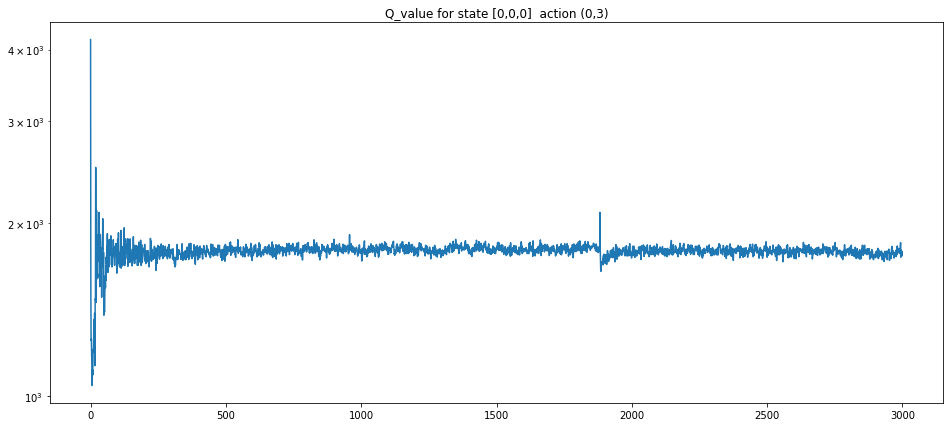

In [18]:
plt.figure(0, figsize=(16,7))
plt.title('Q_value for state [0,0,0]  action (0,3)')
xaxis = np.asarray(range(0, len(agent.states_tracked)))
plt.semilogy(xaxis,np.asarray(agent.states_tracked))
plt.show()

##### We are using log scale because the initial q_values are way to high compared to the steady state value (around 1800)

### 6. Track rewards per episode.

In [14]:
tracked_state_sample = [score_tracked[i] for i in range(len(score_tracked)) if (i % 4 == 0)]

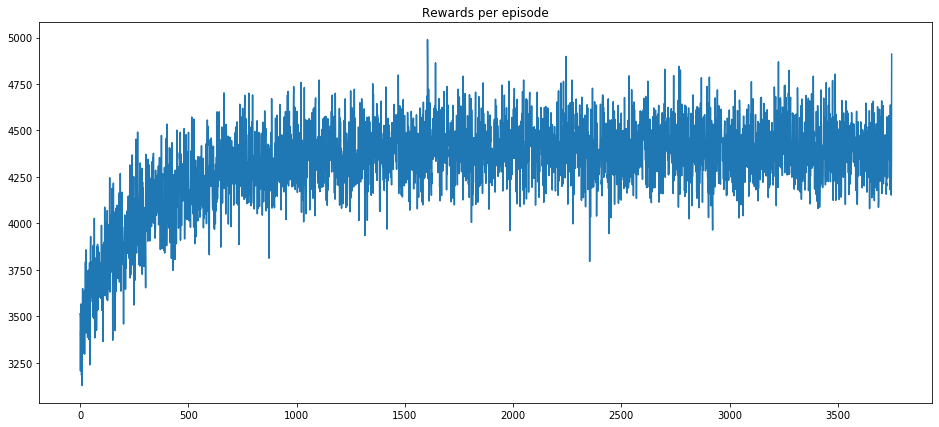

In [16]:
plt.figure(0, figsize=(16,7))
plt.title('Rewards per episode')
xaxis = np.asarray(range(0, len(tracked_state_sample)))
plt.plot(xaxis,np.asarray(tracked_state_sample))
plt.show()

#### We can see from the above plot that the rewards converge at around 4300. Since the initial state is picked to be random for each episode, some initial states may be less rewarding than others inherently regardless of the model quality

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [ ]:
time = np.arange(0,10000)
epsilon = []
for i in range(0,10000):
    epsilon.append(0 + (1 - 0) * np.exp(-0.0009*i))

In [ ]:
plt.plot(time, epsilon)
plt.show()